# Processing

In [ ]:
import pandas as pd
import os

In [ ]:
!git clone https://github.com/adobe-research/deft_corpus

Cloning into 'deft_corpus'...
remote: Enumerating objects: 3207, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 3207 (delta 113), reused 274 (delta 105), pack-reused 2923
Receiving objects: 100% (3207/3207), 41.80 MiB | 9.24 MiB/s, done.
Resolving deltas: 100% (2156/2156), done.


In [ ]:
# for file in sorted(os.listdir('/content/deft_corpus/data/deft_files/train')):
#   path = 'deft_corpus/data/deft_files/train/'+file
#   with open(path, 'r') as f:
#     sentences = f.readlines()

# Baseline BERT

НАДО БУДЕТ ПРОБЕЛАМИ ЗНАКИ ПРЕПИНАНИЯ ОТДЕЛИТЬ

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from transformers import RobertaForTokenClassification, RobertaTokenizer, BertTokenizer, BertForTokenClassification

import tqdm
tqdmn = tqdm.notebook.tqdm

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# train_data_path = 'train_example_normal1.txt'
# val_data_path = 'train_example_normal1.txt'
# test_data_path = 'train_example_normal1.txt'

# with open(train_data_path, 'r') as f:
#   s = f.readlines()

# with open(train_data_path, 'a') as f:
#   f.write('\n')
#   for string in s:
#     f.write(string)

# with open(train_data_path, 'a') as f:
#   f.write('\n')
#   for string in s:
#     f.write(string)

In [ ]:
classes = ['O', 'B-Term', 'I-Term', 'B-Definition', 'I-Definition']
num_classes = len(classes)

In [ ]:
# def txt_to_df(path):
#   df = pd.DataFrame([], columns=['sentence', 'labels'])
#   with open(path, 'r') as f:
#     s = f.readlines()
#     count_sentences = 0
#     df.loc[count_sentences] = ([], [])
#     for string in s:
#       if string=='\n':
#         count_sentences+=1
#         df.loc[count_sentences] = ([], [])
#         continue
#       word, label = string.split('\t')
#       label = label[:-1]
#       df.loc[count_sentences, 'sentence'].append(word)
#       df.loc[count_sentences, 'labels'].append(label)

#   return df


# df_train = txt_to_df(train_data_path)
# df_val = txt_to_df(val_data_path)
# df_test = txt_to_df(test_data_path)

# # with open(train_data_path, 'r') as f:
# df_train

In [ ]:
# model_name = 'ai-forever/ruRoberta-large'
# tokenizer = RobertaTokenizer.from_pretrained(model_name)
# model = RobertaForTokenClassification.from_pretrained(model_name, num_labels=num_classes)
# tokenizer.model_max_length = 512


model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForTokenClassification.from_pretrained(model_name, num_labels=num_classes)
tokenizer.model_max_length = 512

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification

# tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large-finetuned-conll03-english")
# model = AutoModelForTokenClassification.from_pretrained("xlm-roberta-large-finetuned-conll03-english")
# tokenizer.model_max_length = 512

In [ ]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
# model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")
# tokenizer.model_max_length = 512

In [ ]:
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# tokenizer = AutoTokenizer.from_pretrained("51la5/roberta-large-NER")
# model = AutoModelForTokenClassification.from_pretrained("51la5/roberta-large-NER")
# tokenizer.model_max_length = 512

In [ ]:
class NERDataset(Dataset):
    def __init__(self, path_to_files):
        self.sentences, self.labels = self.read_data(path_to_files)
        self.label2id = dict(zip(classes, list(range(len(classes)))))
        self.id2label = {v: k for k, v in self.label2id.items()}

    def read_data(self, path_to_files):
        self.label2id = dict(zip(classes, list(range(len(classes)))))
        sentences = []
        labels = []

        for file_name in tqdmn(sorted(os.listdir(path_to_files)), desc='creating dataset'):
          file_path = path_to_files+ '/' + file_name

          with open(file_path, 'r', encoding='utf-8') as file:
              current_sentence = []
              current_labels = []

              for line in file:
                  if line.strip() == '':
                      if current_sentence:
                          # encodings = tokenizer(current_sentence, truncation=True, padding='max_length', is_split_into_words=True)
                          encodings = tokenizer(current_sentence, truncation=True, is_split_into_words=True)
                          tokens = tokenizer.tokenize(tokenizer.decode(encodings['input_ids'], skip_special_tokens=True))

                          # Find the indices of the beginning of each word in the input sentence
                          word_indices = []
                          count_words = 0
                          current_word = ''
                          for i, token in enumerate(tokens):
                            if not token.startswith("##") and current_word=='':
                              current_word = token
                              word_indices.append(i)
                              # print(token, count_words, current_sentence)
                              # if token[0].lower() != current_sentence[count_words][0].lower():
                              #   continue
                              #   # print(token, current_sentence[count_words])
                              # else:
                              #   word_indices.append(i)
                            elif token.startswith("##"):
                              current_word += token[2:]
                            else:
                              current_word += token

                            if current_word.lower() == current_sentence[count_words].lower():
                                  count_words +=1
                                  current_word = ''

                          real_labels = []

                          # print(word_indices, len(encodings['input_ids']))
                          for i in range(len(word_indices)):
                              start_idx = word_indices[i]
                              end_idx = word_indices[i + 1] if i<len(word_indices)-1 else len(encodings['input_ids'])
                              # print(start_idx, end_idx)
                              real_labels += (end_idx-start_idx)*[current_labels[i]]
                          # print('labels', len(real_labels))
                          # assert len(encodings['input_ids']) == len(real_labels)


                          # current_labels = current_labels + ['O'] * (tokenizer.model_max_length - len(current_labels))
                          # current_labels = current_labels + ['O'] * (len(encodings) - len(current_labels))
                          encodings['input_ids'] = torch.tensor(encodings['input_ids'])
                          encodings['attention_mask'] = torch.tensor(encodings['attention_mask'])
                          sentences.append(encodings)
                          # print(real_labels)
                          current_labels = torch.tensor([self.label2id[label] for label in real_labels])
                          labels.append(current_labels)

                          # assert len(encodings['input_ids']) == len(current_labels)

                          # print(len(encodings['input_ids']), labels)


                          current_sentence = []
                          current_labels = []
                  else:
                      splitted_line = line.split('\t ')
                      word, label = splitted_line[0], splitted_line[4]
                      if label == 'B-Alias-Term':
                        label = 'B-Definition'
                      elif label == 'I-Alias-Term':
                        label = 'I-Definition'
                      elif label == 'B-Secondary-Definition':
                        label = 'B-Definition'
                      elif label == 'I-Secondary-Definition':
                        label = 'I-Definition'

                      elif label == 'B-Ordered-Definition':
                        label = 'B-Definition'
                      elif label == 'I-Ordered-Definition':
                        label = 'I-Definition'
                      elif label == 'B-Ordered-Term':
                        label = 'B-Term'
                      elif label == 'I-Ordered-Term':
                        label = 'I-Term'

                      elif label == 'B-Referential-Definition' or label == 'I-Referential-Definition':
                        label = 'O'

                      elif label == 'B-Qualifier':
                        label = 'B-Definition'
                      elif label == 'I-Qualifier':
                        label = 'I-Definition'

                      elif label == 'B-Referential-Term' or label == 'I-Referential-Term':
                        label = 'O'

                      elif label == 'B-Definition-frag' or label == 'I-Definition-frag':
                        label = label[:-5]

                      elif label == 'B-Term-frag' or label == 'I-Term-frag':
                        label = 'O'

                      elif label == 'B-Alias-Term-frag' or label == 'I-Alias-Term-frag':
                        label = 'O'



                      current_sentence.append(word)
                      current_labels.append(label)

              if current_sentence:
                          # encodings = tokenizer(current_sentence, truncation=True, padding='max_length', is_split_into_words=True)
                          encodings = tokenizer(current_sentence, truncation=True, is_split_into_words=True)
                          tokens = tokenizer.tokenize(tokenizer.decode(encodings['input_ids'], skip_special_tokens=True))

                          # Find the indices of the beginning of each word in the input sentence
                          word_indices = []
                          count_words = 0
                          current_word = ''
                          for i, token in enumerate(tokens):
                            if not token.startswith("##") and current_word=='':
                              current_word = token
                              word_indices.append(i)
                              # print(token, count_words, current_sentence)
                              # if token[0].lower() != current_sentence[count_words][0].lower():
                              #   continue
                              #   # print(token, current_sentence[count_words])
                              # else:
                              #   word_indices.append(i)
                            elif token.startswith("##"):
                              current_word += token[2:]
                            else:
                              current_word += token

                            if current_word.lower() == current_sentence[count_words].lower():
                                  count_words +=1
                                  current_word = ''

                          real_labels = []

                          # print(word_indices, len(encodings['input_ids']))
                          for i in range(len(word_indices)):
                              start_idx = word_indices[i]
                              end_idx = word_indices[i + 1] if i<len(word_indices)-1 else len(encodings['input_ids'])
                              # print(start_idx, end_idx)
                              real_labels += (end_idx-start_idx)*[current_labels[i]]
                          # print('labels', len(real_labels))
                          # assert len(encodings['input_ids']) == len(real_labels)


                          # current_labels = current_labels + ['O'] * (tokenizer.model_max_length - len(current_labels))
                          # current_labels = current_labels + ['O'] * (len(encodings) - len(current_labels))
                          encodings['input_ids'] = torch.tensor(encodings['input_ids'])
                          encodings['attention_mask'] = torch.tensor(encodings['attention_mask'])
                          sentences.append(encodings)
                          # print(real_labels)
                          current_labels = torch.tensor([self.label2id[label] for label in real_labels])
                          labels.append(current_labels)

                          # assert len(encodings['input_ids']) == len(current_labels)

                          # print(len(encodings['input_ids']), labels)


                          current_sentence = []
                          current_labels = []

        return sentences, labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        labels = self.labels[idx]


        return {'input_ids': words['input_ids'], 'attention_mask': words['attention_mask'] ,'labels': labels}
        return words, label_ids


train_dataset = NERDataset('/content/deft_corpus/data/deft_files/train')

val_dataset = NERDataset('/content/deft_corpus/data/deft_files/dev')

creating dataset:   0%|          | 0/80 [00:00<?, ?it/s]

creating dataset:   0%|          | 0/68 [00:00<?, ?it/s]

In [ ]:
for di in train_dataset:
  if not di['input_ids'].shape == di['attention_mask'].shape == di['labels'].shape:
    print(di['input_ids'].shape, di['attention_mask'].shape, di['labels'].shape)

In [ ]:
# for key in val_dataset[5].keys():
#   print(val_dataset[5][key].shape)

In [ ]:
label2id = dict(zip(classes, list(range(len(classes)))))
id2label = {v: k for k, v in label2id.items()}

In [ ]:
model.config.id2label = id2label
model.config.label2id = label2id

In [ ]:
# model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.train().to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)

In [ ]:
class PadSequence:
    def __call__(self, batch):
      lengths = [el['input_ids'].shape[0] for el in batch]
      max_len = max(lengths)
      # print('MAX_LENGHFNLSKMV', max_len)

      for i in range(len(batch)):
        # print(batch[i]['input_ids'].shape, batch[i]['attention_mask'].shape, batch[i]['labels'].shape)
        difference = max_len - lengths[i]
        # print(max_len, difference)
        batch[i]['input_ids'] = torch.cat([batch[i]['input_ids'], torch.tensor([0]*difference)])
        batch[i]['attention_mask'] = torch.cat([batch[i]['attention_mask'], torch.tensor([0]*difference)])
        batch[i]['labels'] = torch.cat([batch[i]['labels'], torch.tensor([0]*difference)])
        # print(batch[i]['input_ids'].shape, batch[i]['attention_mask'].shape, batch[i]['labels'].shape)
        # print('-'*50)

      batch = {'input_ids': torch.stack([batch[i]['input_ids'] for i in range(len(batch))]),
               'attention_mask': torch.stack([batch[i]['attention_mask'] for i in range(len(batch))]),
               'labels': torch.stack([batch[i]['labels'] for i in range(len(batch))]),}

      return batch

In [ ]:
n_epochs = 20
batch_size = 64
val_batch_size = 64
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=PadSequence())
val_data = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, collate_fn=PadSequence())
# test_data = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!mkdir checkpoints

In [ ]:
train_loss = []
val_loss = []

train_f1_scores = []
val_f1_scores = []

for epoch in tqdmn(range(n_epochs)):
    confusion_train = torch.zeros(num_classes, num_classes)
    confusion_val = torch.zeros(num_classes, num_classes)
    train_loss_epoch = []
    val_loss_epoch = []
    # iterate through each batch of the train data
    for i, batch in enumerate(tqdmn(train_data)):
        optimizer.zero_grad()

        batch = { k: v.long().to(device) for k, v in batch.items() }

        outputs = model(**batch)


        # get the sentence lengths
        s_lengths = batch['attention_mask'].sum(dim=1)
        # iterate through the examples
        for idx, length in enumerate(s_lengths):
            # get the true values
            true_values = batch['labels'][idx][:length]
            # get the predicted values
            pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
            # go through all true and predicted values and store them in the confusion matrix
            for true, pred in zip(true_values, pred_values):
                confusion_train[true.item()][pred.item()] += 1

        loss = outputs[0]
        loss.backward()

        train_loss_epoch.append(loss.item())
        optimizer.step()

        del batch
        torch.cuda.empty_cache()

    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }

    torch.save(checkpoint, f'checkpoints/{epoch}_weights')

    with torch.no_grad():
      for i, batch in enumerate(tqdmn(val_data)):
        batch = { k: v.long().to(device) for k, v in batch.items() }
        outputs = model(**batch)

        # get the sentence lengths
        s_lengths = batch['attention_mask'].sum(dim=1)
        # iterate through the examples
        for idx, length in enumerate(s_lengths):
            # get the true values
            true_values = batch['labels'][idx][:length]
            # get the predicted values
            pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
            # go through all true and predicted values and store them in the confusion matrix
            for true, pred in zip(true_values, pred_values):
                confusion_val[true.item()][pred.item()] += 1

        loss = outputs[0]

        val_loss_epoch.append(loss.item())

        del batch
        torch.cuda.empty_cache()

    train_loss_epoch, val_loss_epoch = sum(train_loss_epoch)/len(train_loss_epoch), sum(val_loss_epoch)/len(val_loss_epoch)
    print(f'Epoch {epoch}. Train Loss: {train_loss_epoch}. Val Loss: {val_loss_epoch}')

    precision = np.diag(confusion_train) / torch.sum(confusion_train, axis=0)
    recall = np.diag(confusion_train) / torch.sum(confusion_train, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)

    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1_score = f1_score.mean()

    train_f1_scores.append(macro_f1_score)

    print("Train Macro-Averaged Precision:", macro_precision.item(), "Macro-Averaged Recall:", macro_recall.item(), "Macro-Averaged F1-score:", macro_f1_score.item())

    precision = np.diag(confusion_val) / torch.sum(confusion_val, axis=0)
    recall = np.diag(confusion_val) / torch.sum(confusion_val, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)

    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1_score = f1_score.mean()

    val_f1_scores.append(macro_f1_score)

    print("Validation Macro-Averaged Precision:", macro_precision.item(), "Macro-Averaged Recall:", macro_recall.item(), "Macro-Averaged F1-score:", macro_f1_score.item())



    train_loss.append(train_loss_epoch)
    train_loss.append(val_loss_epoch)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 0. Train Loss: 0.12370934028907743. Val Loss: 0.1352151312718266
Train Macro-Averaged Precision: 0.7035967111587524 Macro-Averaged Recall: 0.5806981921195984 Macro-Averaged F1-score: 0.6255828738212585
Validation Macro-Averaged Precision: 0.6977723836898804 Macro-Averaged Recall: 0.6323763132095337 Macro-Averaged F1-score: 0.6581702828407288


  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1. Train Loss: 0.10389456282019931. Val Loss: 0.1324050624511744
Train Macro-Averaged Precision: 0.7494038343429565 Macro-Averaged Recall: 0.6698026061058044 Macro-Averaged F1-score: 0.7028299570083618
Validation Macro-Averaged Precision: 0.7711206078529358 Macro-Averaged Recall: 0.574662983417511 Macro-Averaged F1-score: 0.6452949047088623


  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2. Train Loss: 0.08789482963562169. Val Loss: 0.1317120612059769
Train Macro-Averaged Precision: 0.7828892469406128 Macro-Averaged Recall: 0.7280395030975342 Macro-Averaged F1-score: 0.7520198822021484
Validation Macro-Averaged Precision: 0.7602331638336182 Macro-Averaged Recall: 0.6456583738327026 Macro-Averaged F1-score: 0.6933780312538147


  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3. Train Loss: 0.07604137501585737. Val Loss: 0.1360223903075645
Train Macro-Averaged Precision: 0.8030027151107788 Macro-Averaged Recall: 0.7632770538330078 Macro-Averaged F1-score: 0.7810811996459961
Validation Macro-Averaged Precision: 0.7538430690765381 Macro-Averaged Recall: 0.6647559404373169 Macro-Averaged F1-score: 0.703335702419281


  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4. Train Loss: 0.06603788244956858. Val Loss: 0.137434815105639
Train Macro-Averaged Precision: 0.8224430084228516 Macro-Averaged Recall: 0.792098343372345 Macro-Averaged F1-score: 0.8059319257736206
Validation Macro-Averaged Precision: 0.7793818712234497 Macro-Averaged Recall: 0.6475509405136108 Macro-Averaged F1-score: 0.7011674046516418


  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5. Train Loss: 0.057491251853881056. Val Loss: 0.15098737435121284
Train Macro-Averaged Precision: 0.8344047665596008 Macro-Averaged Recall: 0.8111845850944519 Macro-Averaged F1-score: 0.8218588829040527
Validation Macro-Averaged Precision: 0.751822829246521 Macro-Averaged Recall: 0.7077246904373169 Macro-Averaged F1-score: 0.7277963161468506


  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6. Train Loss: 0.05257826916893166. Val Loss: 0.16655036865880615
Train Macro-Averaged Precision: 0.8452475666999817 Macro-Averaged Recall: 0.828128457069397 Macro-Averaged F1-score: 0.8359836339950562
Validation Macro-Averaged Precision: 0.7492271661758423 Macro-Averaged Recall: 0.7014414072036743 Macro-Averaged F1-score: 0.7230459451675415


  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7. Train Loss: 0.04798743403984835. Val Loss: 0.16413526433078865
Train Macro-Averaged Precision: 0.8533614277839661 Macro-Averaged Recall: 0.8410607576370239 Macro-Averaged F1-score: 0.8467332720756531
Validation Macro-Averaged Precision: 0.7682393789291382 Macro-Averaged Recall: 0.7037572264671326 Macro-Averaged F1-score: 0.73304283618927


  0%|          | 0/378 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8. Train Loss: 0.04466537342569421. Val Loss: 0.16382967935580955
Train Macro-Averaged Precision: 0.8615123629570007 Macro-Averaged Recall: 0.8503645062446594 Macro-Averaged F1-score: 0.8555095791816711
Validation Macro-Averaged Precision: 0.7277787327766418 Macro-Averaged Recall: 0.7325516939163208 Macro-Averaged F1-score: 0.7283679246902466


  0%|          | 0/378 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), 'weights')

In [ ]:
np.diag(confusion_train)/np.sum(confusion_train.numpy(), axis=0)

<ipython-input-28-d21eab7efdf3>:1: RuntimeWarning: invalid value encountered in divide
  np.diag(confusion_train)/np.sum(confusion_train.numpy(), axis=0)


array([0.8259209, 0.       , 0.5294118,       nan, 0.776378 ],
      dtype=float32)

Epoch 0. Train Loss: 0.014000404954537244. Val Loss: 0.008116368401794189

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
# visualize the loss values
ax.plot(train_loss)
ax.plot(val_loss)
# set the labels
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations')
fig.tight_layout()
plt.show()

NameError: ignored

In [ ]:
model = model.eval()

# create the confusion matrix
confusion = torch.zeros(num_classes, num_classes)


for i, batch in enumerate(tqdmn(val_data)):

    with torch.no_grad():

        batch = { k: v.long().to(device) for k, v in batch.items() }

        outputs = model(**batch)

    # get the sentence lengths
    s_lengths = batch['attention_mask'].sum(dim=1)
    # iterate through the examples
    for idx, length in enumerate(s_lengths):
        # get the true values
        true_values = batch['labels'][idx][:length]
        # get the predicted values
        pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
        # go through all true and predicted values and store them in the confusion matrix
        for true, pred in zip(true_values, pred_values):
            confusion[true.item()][pred.item()] += 1

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
# Normalize by dividing every row by its sum
for i in range(num_classes):
    confusion[i] = confusion[i] / confusion[i].sum() if confusion[i].sum()!=0 else 0

In [ ]:
confusion

tensor([[0.9117, 0.0075, 0.0103, 0.0046, 0.0658],
        [0.2029, 0.7275, 0.0492, 0.0102, 0.0102],
        [0.2266, 0.0225, 0.7266, 0.0000, 0.0242],
        [0.3325, 0.0567, 0.0026, 0.5052, 0.1031],
        [0.2522, 0.0023, 0.0078, 0.0063, 0.7314]])

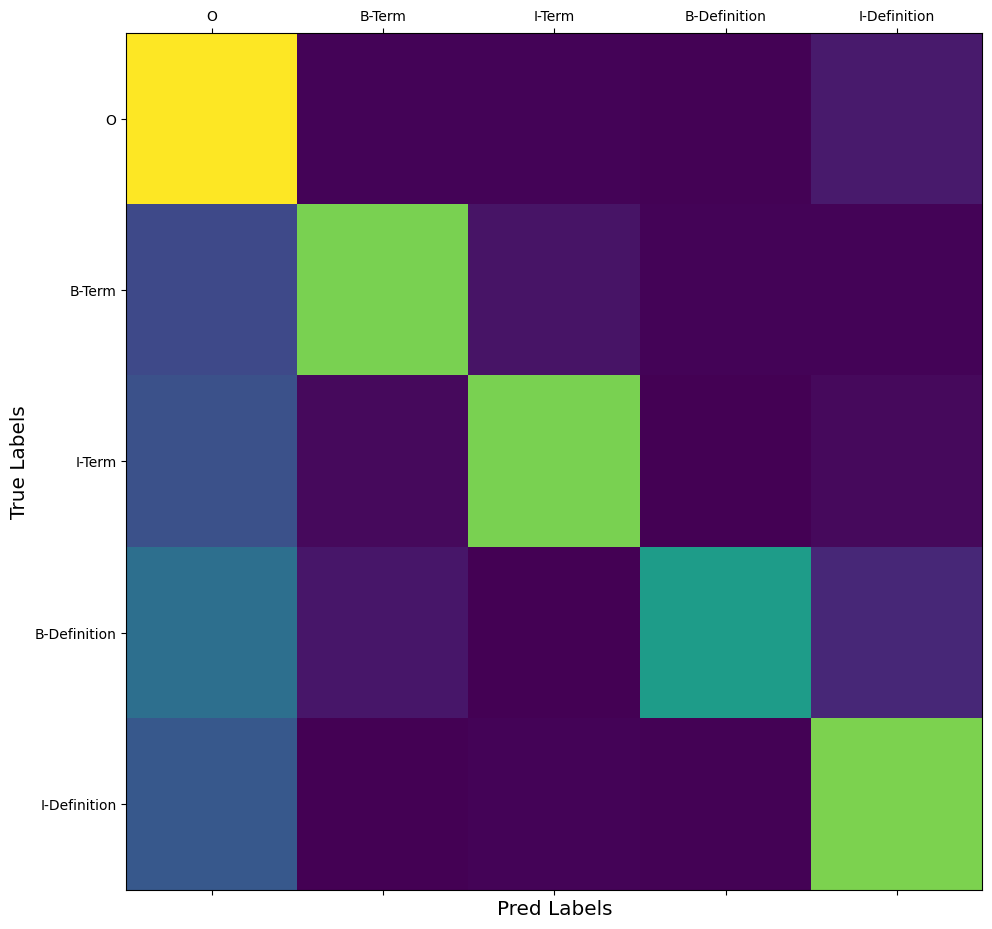

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
# visualize the loss values
ax.matshow(confusion.numpy())

# get the labels
labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

# set the x ticks
ax.set_xticks(ids)
ax.set_xticklabels(labels)

# set the y ticks
ax.set_yticks(ids)
ax.set_yticklabels(labels)

# plot figure
fig.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/ЦП_хакатон/weights1')

In [ ]:
model = torch.load('definition_extraction_weights')
model.eval()

In [ ]:
# create the confusion matrix
confusion = torch.zeros(num_classes, num_classes)


for i, batch in enumerate(tqdmn(test_data)):

    with torch.no_grad():

        batch = { k: v.to(device) for k, v in batch.items() }

        outputs = model(**batch)

    # get the sentence lengths
    s_lengths = batch['attention_mask'].sum(dim=1)
    # iterate through the examples
    for idx, length in enumerate(s_lengths):
        # get the true values
        true_values = batch['labels'][idx][:length]
        # get the predicted values
        pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
        # go through all true and predicted values and store them in the confusion matrix
        for true, pred in zip(true_values, pred_values):
            confusion[true.item()][pred.item()] += 1
confusion

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
# !cp /content/definition_extraction_weights /content/drive/MyDrive/ЦП_хакатон/definition_extraction_weights

# Experiments